A. Loading the Online Retail Dataset

In [123]:
# Import python libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [124]:
# Load data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
data = pd.read_excel(url)

B. Preprocessing and EDA

In [125]:
# EDA
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [126]:
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [127]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [128]:
missing_values = data.isnull().sum()
print(missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [129]:
# Preprocessing: Clean data by removing missing values
data.dropna(subset=['CustomerID'], inplace = True)

In [130]:
# Preprocessing: Clean data by removing negative values
data = data[(data['Quantity'] > 0) & (data['UnitPrice'] > 0)]

In [131]:
# Preprocessing: Cast CustomerID to int
data['CustomerID'] = data['CustomerID'].astype(int)

In [132]:
print(data.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
dtype: object


C. Calculate Recency, Frequency, and Monetary Value

In [133]:
# Set snapshot date as a date later than the most recent date in the dataset
snapshot_date = max(data['InvoiceDate']) + pd.DateOffset(days=1)

In [134]:
# Calculate the total value of transactions
data['Total'] = data['Quantity'] * data['UnitPrice']

In [135]:
# Grouping by Customer, calculate recency, frequency, and monetary value
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'Total': 'sum'
})

In [136]:
# Rename columns
rfm = rfm.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo' : 'Frequency', 'Total': 'Monetary Value'})
rfm.head()

,Recency,Frequency,Monetary Value
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [137]:
rfm.describe()

,Recency,Frequency,Monetary Value
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


D. Map RFM Values onto a Scale of 1-5

In [138]:
# Define bin edges to define scale of 1-5
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min()-1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['Monetary Value'].min()-3, 300, 600, 2000, 5000, rfm['Monetary Value'].max()]

In [139]:
# Map RFM values
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels = range(1,6), include_lowest = True)
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels = range(1,6), include_lowest = True).astype(int)

rfm['M_Score'] = pd.cut(rfm['Monetary Value'], bins=monetary_bins, labels = range(1,6), include_lowest = True).astype(int)


In [150]:
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))

            R_Score  F_Score  M_Score
CustomerID                           
12346             1        1        5
12347             5        3        4
12348             3        3        3
12349             5        1        3
12350             1        1        2
12352             4        3        4
12353             2        1        1
12354             2        1        3
12355             2        1        2
12356             4        2        4


E. K-Means Clustering

In [141]:
# K Means Clustering
X = rfm[['R_Score', 'F_Score', 'M_Score']]

In [142]:
# Calculate inertia (sum of squared distances to closest cluster center) for range of k values to determine best K using elbow method
inertia = []
for k in range(2,11):
    classifier = KMeans(n_clusters=k, n_init=10, random_state = 42)
    classifier.fit(X)
    inertia.append(classifier.inertia_)

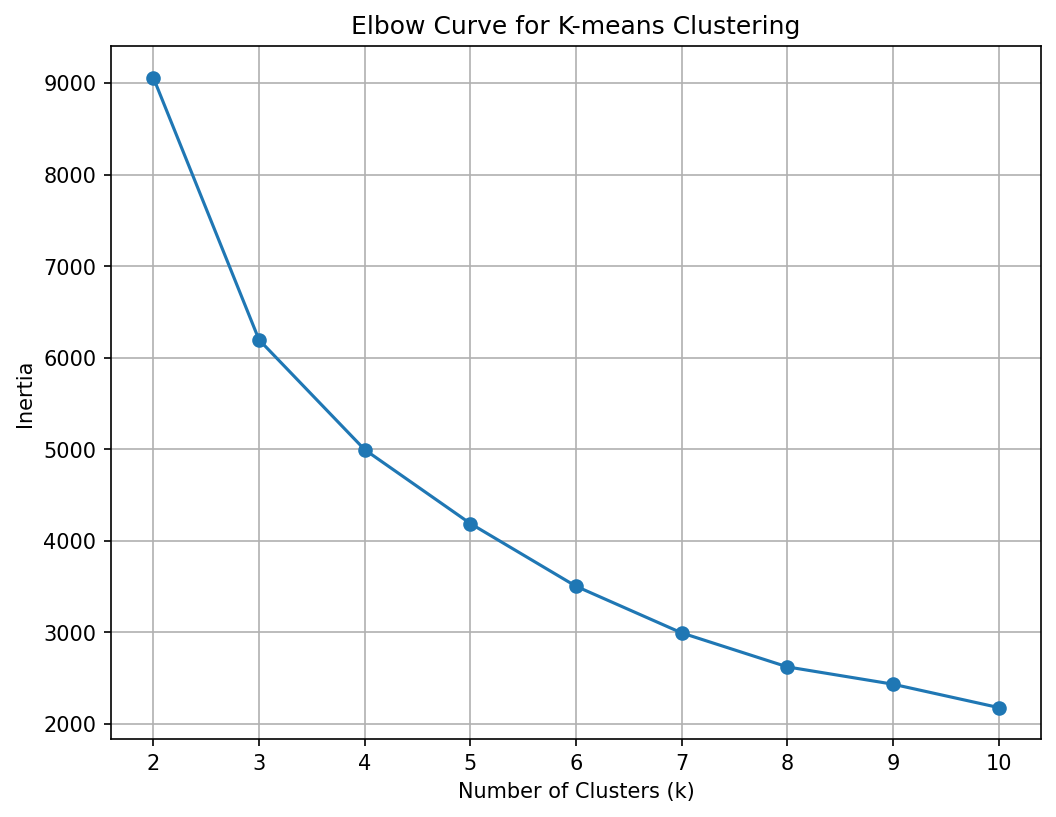

In [143]:
# Plot elbow curve
plt.figure(figsize=(8,6), dpi=150)
plt.plot(range(2,11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

Elbow is at K = 4, so we will use 4 clusters for K Means clustering to calculate the accuracy

F. K-Means Clustering with K=4

In [144]:
# Perform K-Means Clustering with k=4
k4_classifier = KMeans(n_clusters=4, n_init=10, random_state = 42)
k4_classifier.fit(X)
rfm['Cluster with k = 4'] = k4_classifier.predict(X)

G. Interpret Clusters to Identify Customer Segments 

In [145]:
# Group by cluster and characterize 
cluster_summary = rfm.groupby('Cluster with k = 4').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()


In [146]:
print(cluster_summary)

   Cluster with k = 4   R_Score   F_Score   M_Score
0                   0  1.442263  1.061201  1.505774
1                   1  3.013043  1.619130  2.820870
2                   2  4.550798  3.169086  3.774311
3                   3  4.092161  1.103814  1.505297


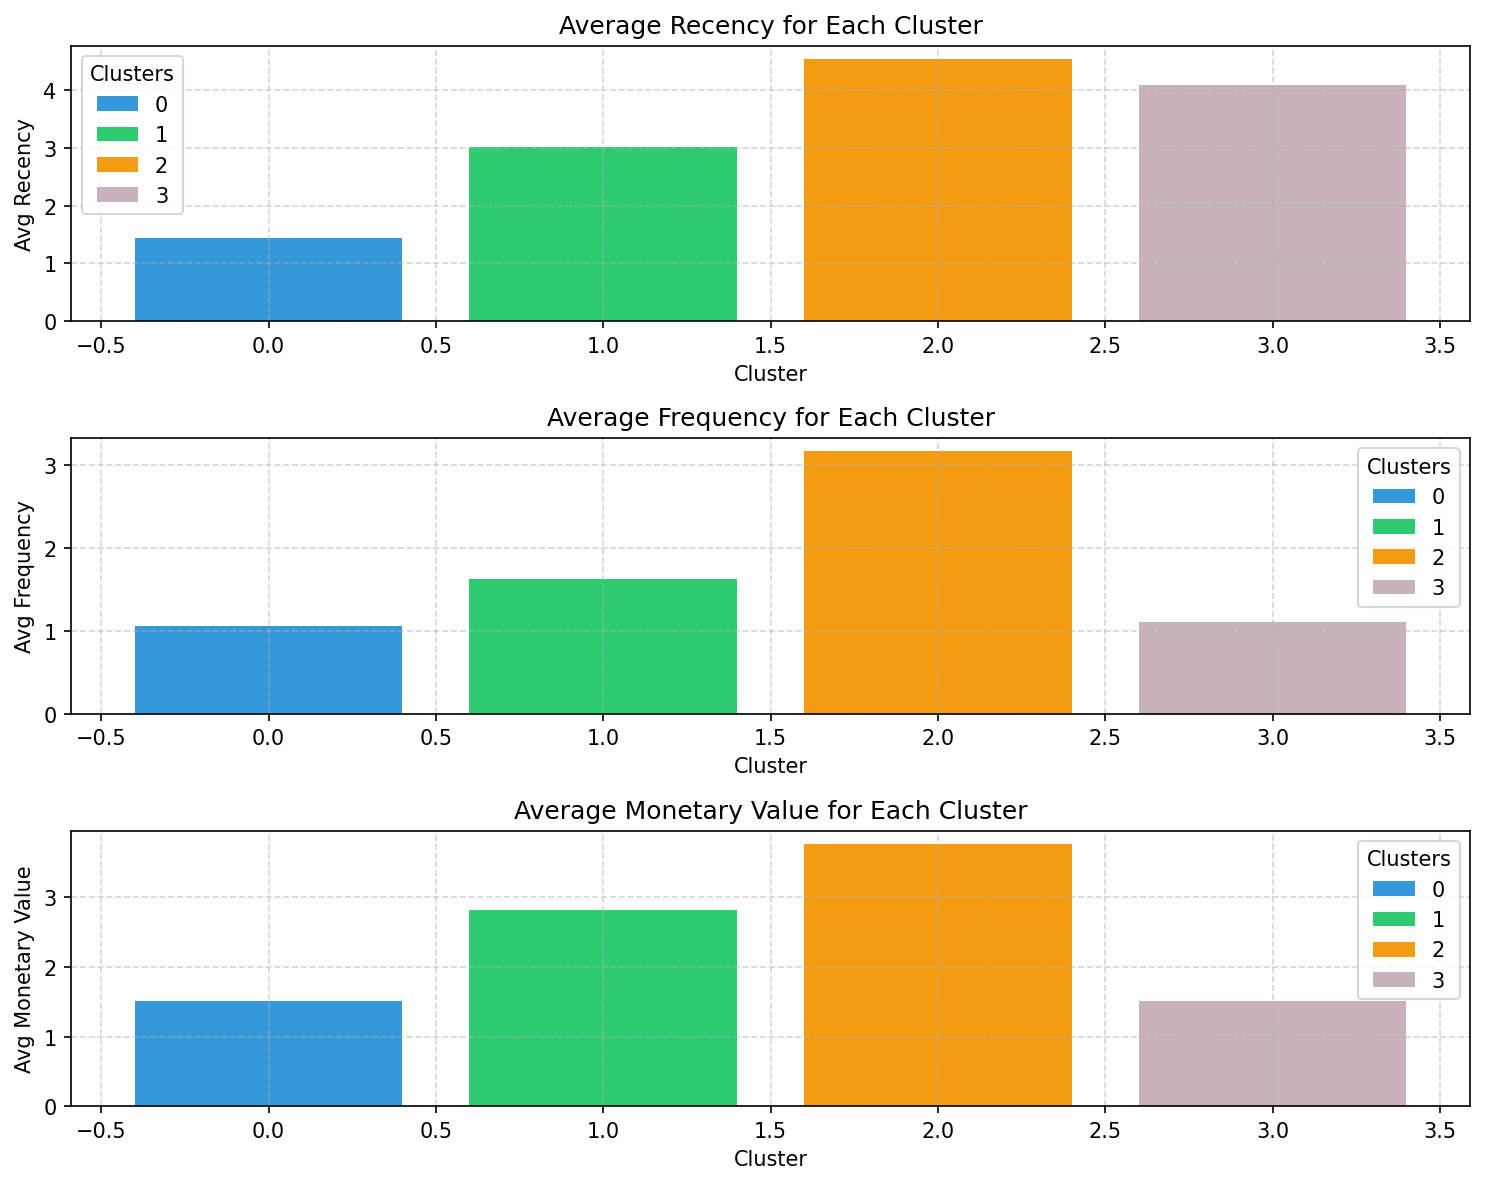

In [147]:
 # Visualize average cluster characteristics 
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
plt.figure(figsize=(10, 8),dpi=150)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3,1,2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary Value
plt.subplot(3,1,3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary Value')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

In [148]:
# Visualize percentage of customers in each segment
cluster_counts = rfm['Cluster with k = 4'].value_counts()
#print(cluster_counts)

total_customers = cluster_counts.sum()
percentage_customers = cluster_counts / total_customers * 100
print(percentage_customers)


Cluster with k = 4
2    31.765791
1    26.509912
3    21.761180
0    19.963117
Name: count, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

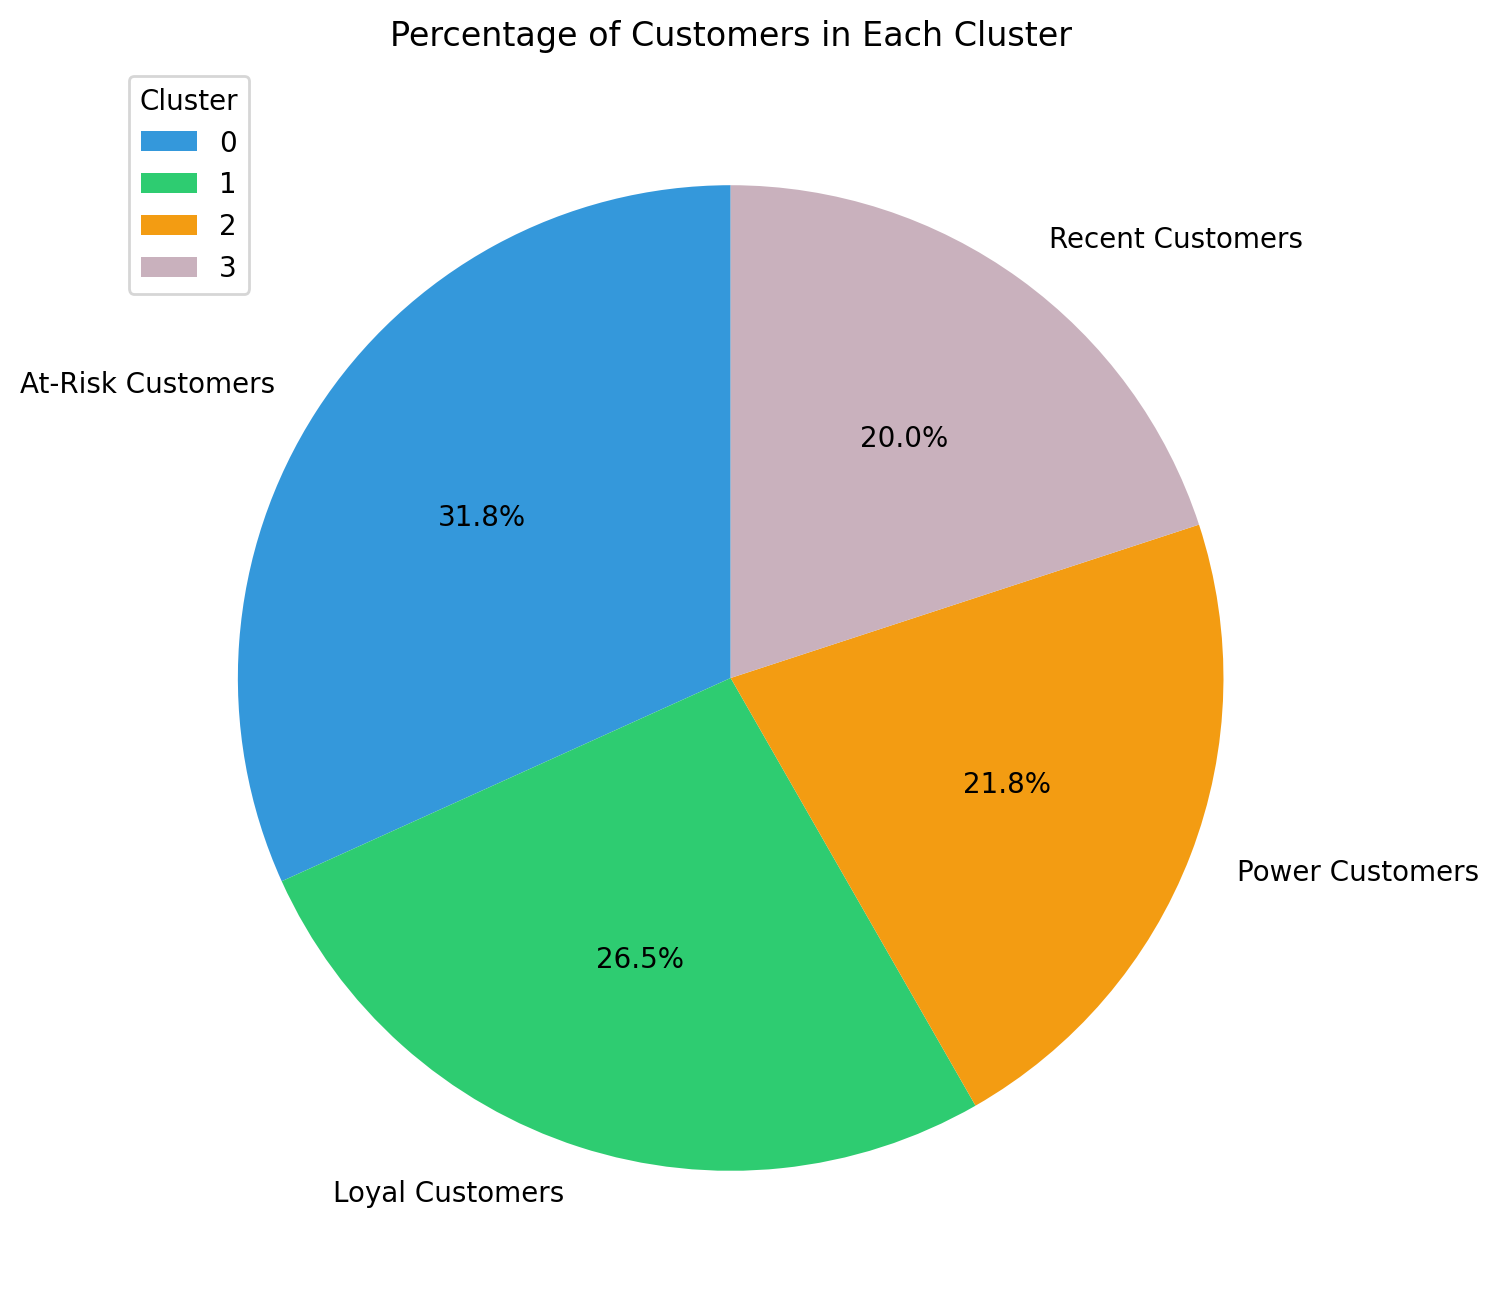

In [151]:
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
labels = ['At-Risk Customers','Loyal Customers','Power Customers','Recent Customers']

plt.figure(figsize=(8,8), dpi=200)
plt.pie(percentage_customers, labels = labels, colors = colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster with k = 4'], title='Cluster', loc='upper left')
plt.show


H. Analysis and Results

The clusters are characterized based on Recency, Frequency, and Monetary values as follows: 

Cluster 0: Characterized by low recency, frequency, and monetary value. Customers in this segment are at-risk, and the company can reengage them by sending them new offers and deals to promote making the next purchase.

Cluster 1: Characterized by the moderate recency, frequency, and monetary value. Customers in this segment can be considered loyalty customers, and the company can retain this segment by offering rewards campaigns.

Cluster 2: Characterized by the highest recency, frequency, and monetary value. Therefore, customers in this segment can be considered "power customers", and the company can grow  this segment by offering premium rewards and perks.

Cluster 3: Charactered by low frequency but high recency. Customers in this segment are new to shopping with the company. The company can grow this segment by targetting new customers with campaigns to encourge subsequent purchases to convert them into loyalty customers.

